# Model 1

This notebboks shows a basic usage example of the `Model1` for the railway scheduling problem. This model solves the railwayscheduling problem using the branch & bounds algorithm implemented in Gurobi with the prior addition that the simulated annealing meta-heuristic is used to generate an initial solution for the problem.

To initialize the model the following imports are needed.

In [1]:
import os
import sys
import numpy as np
from railway import *

We then change the directory to the root folder of the project in order to correctly load the datasets.\
⚠ **WARNING**: change the path below, which might differ from mine, according to your file system setting in order to correctly load the datasets.

In [2]:
# Root folder directory
ROOT_DIR = "/home/marco/railway-scheduling"

# Set the current directory to root directory
os.chdir(ROOT_DIR)
sys.path.append(os.getcwd())
print(f"Current working directory: 📂 {os.getcwd()}")

Current working directory: 📂 /home/marco/railway-scheduling


We can then initialize the railway scheduling problem by loading one of the datasets present in the `datasets/` folder. To do so we need to define the parameters:

- `N`: number of nodes (stations), with $N \in \{10, 20, 40\}$
- `T`: time horizon, with $T \in \{10, 50, 100\}$
- `J`: number of jobs, with $J \in \{10, 40, 80\}$
- `P`: total number of passengers per arc, currently only $P = 2000$ is available
- `K`: number of alternative routes, currently only $K = 3$ is available

And the problem can be instantiated as follows. Notice that we use the same class as in the `Model0` notebook, the difference will be in which methods we call before the optimization step.

In [5]:
# Define problem parameters
N = 10
T = 10
J = 10
P = 2000
K = 3

# Name of the file to load
FILENAME = f"datasets/railway_N{N}_T{T}_J{J}_P{P}_K{K}.json"

# Instantiate the Railway object
rail = Railway.load(FILENAME)

# Print the model in summary
print(rail)

Railway scheduling problem

Parameters:
N:  10 stations
T:  10 periods
J:  10 jobs
P:  2000 passengers
K:  3 alternative routes
Aj: 10 jobs with arcs
Ja: 9 arcs with jobs
C:  0 arcs unavailable simultaneously

Optimization model:
Variables:   0
Constraints: 0
Objective:   0.0
Status:      LOADED



Alternatively the model can be initialized using the default constructor rather than importing it from a dataset file:

```python
rail = Railway(N, T, J, P, K)
```

But then the other problem parameters such as stations coordinates or passengers' demands must be randomly generated with the `generate()` method. See the `apps/generate.py` file for an example on how to do that.

Now we want to generate a good initial solution `S` for the problem. To do it will be sufficient to just call the `generate_initial_solution()` method like so:

```python
S = rail.generate_initial_solution()
print(S)
```

However, for the sake of this example, in the following cell we will show the inner working of the implemented `simulated_annealing()` method explicitly to visualize how the initial solution is generated.

In [8]:
# Simulated annealing (SA) for intial solution generation

# First of all we set the parameters for the SA algorithm
T = 5000
c = 0.99
L = 1
max_iter = 10000
min_temperature = 1e-6

# Then we initialize a starting solution and the iteration counter
S = rail.generate_initial_solution()
iter = 0

# We also initialize a list to store the values of the objective function
_, _, _, _, v = rail.get_vars_from_times(S)
objective_values = [rail.get_objective_value(v)]

# We also need to keep trak of the best solution found so far,
# just in case the algorithm terminates in a suboptimal state
best_S = S.copy()
best_obj = objective_values[-1]

# Simulated annealing (SA) algorithm
while (T > min_temperature) and (iter < max_iter):
    for _ in range(L):
        # Generate a new (neighbor) solution
        S_new = rail.generate_neighbor_solution(S)

        # Get the solutions' variables
        _, _, _, _, v = rail.get_vars_from_times(S)
        _, _, _, _, v_new = rail.get_vars_from_times(S_new)

        # Compute the objective function values
        f = rail.get_objective_value(v)
        f_new = rail.get_objective_value(v_new)

        # Accept solution if it's better or with a certain probability
        if f_new <= f:
            S = S_new
            objective_values.append(f_new)
            # Update the best found solution only if it's truly the best
            if f_new < best_obj:
                best_S = S_new.copy()
                best_obj = f_new
        else:
            p = np.exp((f - f_new) / T)
            if np.random.rand() < p:
                S = S_new
                objective_values.append(f_new)

    # Cool down the temperature
    T *= c

    # Increment the iteration counter
    iter += 1
 
# Final solution with SA
print(f"Total number of iterations:\t{iter}")
print(f"Initial solution with SA:\t{S}")
print(f"Objective value of initial solution:\t{objective_values[-1]}")

Total number of iterations:	2223
Initial solution with SA:	{1: 9, 2: 4, 3: 1, 4: 1, 5: 1, 6: 1, 7: 6, 8: 8, 9: 1, 10: 2}
Objective value of initial solution:	40194.17908216138


We can also plot the values of the objective function through the iterations of the simulated annealing algorithm to see the trend of the initial solution improvement.

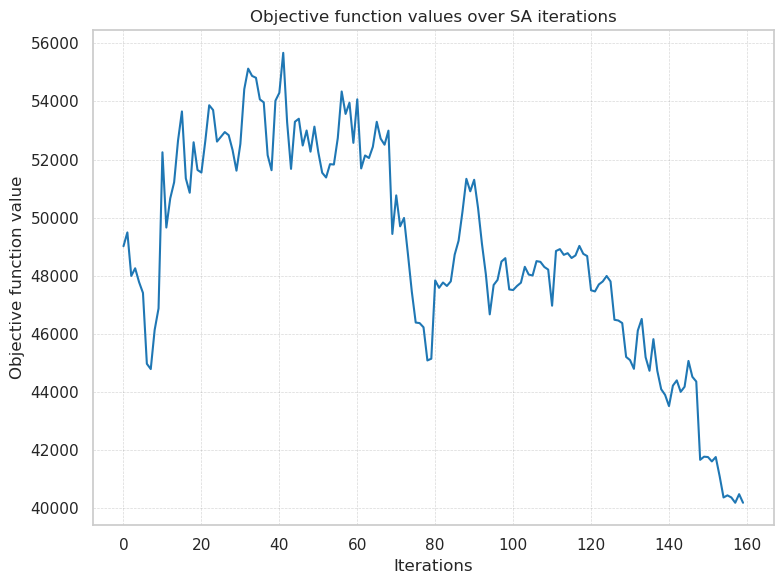

In [10]:
# Import and set style for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    style="whitegrid",
    palette="tab10",
    rc={
        "grid.linestyle": "--",
        "grid.color": "gray",
        "grid.alpha": 0.3,
        "grid.linewidth": 0.5,
    },
)

# Plot the objective function values
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(len(objective_values)), y=objective_values)
plt.title("Objective function values over SA iterations")
plt.xlabel("Iterations")
plt.ylabel("Objective function value")
plt.grid(True)
plt.tight_layout()
plt.show()

Notice that the components of the `objective_values` list might be less than the total number of iterations because the neighbor solution is not always accepted during the SA algorithm...

After the initial solution has been generated through simulated annealing we can set it as the current solution of the problem with the `set_solution()` method, which internally sets the corresponding starting values for all the variables and runs the `update()` method required by Gurobi models for the changes to take effect.

In [11]:
# Set the initial solution
rail.set_solution(S)

Then, we can set the problem parameters, constraints and the objective function to minimize with the dedicated methods.

In [12]:
# Set model1 parameters
rail.set_model1(timelimit=60, verbose=True)

# Set constraints
rail.set_constraints()

# Set objective
rail.set_objective()

Set parameter TimeLimit to value 60
Set parameter PoolSolutions to value 1
Set parameter Cuts to value 0
Set parameter CutPasses to value 0
Set parameter Heuristics to value 0
Set parameter Symmetry to value 0
Set parameter Threads to value 1
Set parameter Presolve to value 0
Set parameter NumericFocus to value 3


Finally the optimization can be run with the `optimize` method.

In [13]:
# Solve the scheduling problem
rail.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 1 threads

Non-default parameters:
TimeLimit  60
Heuristics  0
Symmetry  0
Cuts  0
CutPasses  0
NumericFocus  3
Presolve  0
Threads  1
PoolSolutions  1

Optimize a model with 9805 rows, 4600 columns and 43208 nonzeros
Model fingerprint: 0xa6508de1
Variable types: 1350 continuous, 3250 integer (3250 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [2e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+05]

Loaded user MIP start with objective 40194.2

Variable types: 1310 continuous, 3290 integer (3250 binary)

Root relaxation: objective -3.679294e+05, 774 iterations, 0.11 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

{'runtime': 0.39075803756713867,
 'nodes': 3.0,
 'iterations': 814.0,
 'gap': 0.0,
 'obj': 35911.37598267663}

After the optimization we can compare the optimal solution found with the initial one generated by the simulated annealing algorithm to see how close it actually was.

In [14]:
# Compare initial solution and optimal one
print(f"Objective value of initial solution:\t{objective_values[-1]}")
print(f"Objective value of optimal solution:\t{rail.model.getObjective().getValue()}")

# Print initial solution schedule and optimal one
print(f"Initial solution schedule:\t {S}")
print(f"Optimal solution schedule:\t {rail.S}")

Objective value of initial solution:	40194.17908216138
Objective value of optimal solution:	35911.37598267873
Initial solution schedule:	 {1: 9, 2: 4, 3: 1, 4: 1, 5: 1, 6: 1, 7: 6, 8: 8, 9: 1, 10: 2}
Optimal solution schedule:	 {1: 9, 2: 8, 3: 1, 4: 1, 5: 1, 6: 2, 7: 6, 8: 0, 9: 0, 10: 2}
